Part 3: DNA binding classifier

again, help from Isaiah Hazelwood and ChatGPT 

loading prerequisites and data

In [4]:
from nn import nn 
from nn import io 
from nn import preprocess
import sklearn
import numpy as np 
import matplotlib.pyplot as plt

In [5]:
positive_seqs = io.read_text_file("./data/rap1-lieb-positives.txt")
negative_seqs = io.read_fasta_file("./data/yeast-upstream-1k-negative.fa")
#negative sequences are 1000 characters while positives are 17 characters long
#need to have same length of positive and negative examples
#need to randomly select 17-character long substring from each negative sequence
np.random.seed(42)
negative_seqs_trimmed = []
for negative_seq in negative_seqs:
    i = np.random.randint(len(negative_seq) - 17 + 1) #random starting position
    negative_seqs_trimmed.append(negative_seq[i:i+17])

#generate a full sequence list 
seqs = positive_seqs + negative_seqs_trimmed
labels = ([True] * len(positive_seqs)) + ([False] * len(negative_seqs_trimmed))

#randomly sample sequences to account for class imbalance 
sampled_seqs, sampled_labels = preprocess.sample_seqs(seqs, labels)

#now I'm encoding the sequences
sample_seqs_encoded = preprocess.one_hot_encode_seqs(sampled_seqs)

#randomly split sequences into training and validation sets
indexes_permuted = np.random.permutation(len(sampled_labels))
train_indices = indexes_permuted[:len(sample_seqs_encoded) * 7 // 10]
val_indices = indexes_permuted[len(sample_seqs_encoded) * 7 // 10:]
"""
because encoded means sequence length * 4 (encoder length) = 17 * 4 = 68
so list of sequences having length 68 as encoded amino acids, represented as flat arrays. 
without reshaping, I would get (num_samples, 68) after calling np.array([sampled_seqs_encoded[i] for i in train_indices])
each row representing one sequence (sample) and each column represents one encoded character
in ML the neural network expects a clearly defined 3-D shape as input (batch_size, sequence_length, num_channels)
so number of samples in a batch -> if -1, numpy infers this automatically, 
sequence_lenght is 68 in my case, num_channels is number of features per position and because
each position in my sequence is represented by a single numeric value (one-hot encoded aa) this would typically be 1
for numerical sequences channel usually is 1. 
"""
seqs_train = np.array([sample_seqs_encoded[i] for i in train_indices]).reshape(-1, 68)
#labels_train without reshaping (500,0), need to reshape to represent in 3D
labels_train = np.array([sampled_labels[i] for i in train_indices]).astype(np.float64).reshape(-1, 1)
seqs_val = np.array([sample_seqs_encoded[i] for i in val_indices]).reshape(-1, 68)
labels_val = np.array([sampled_labels[i] for i in val_indices]).astype(np.float64).reshape(-1, 1)

#sampling number of less frequent class equal to number of data points from most frequent class (with replacement) ensures that all 
#the data is being used in thhe training process. 

Defining and training the classifier

In [6]:
#define the classifier
dna_classifier = nn.NeuralNetwork([{"input_dim":17 * 4, "output_dim": 20, "activation": "relu"},
                                  {"input_dim": 20, "output_dim":5, "activation":"relu"},
                                  {"input_dim":5, "output_dim":1, "activation":"sigmoid"}],
                                  lr=0.015,
                                  seed=42,
                                  batch_size=20, 
                                  epochs=7,
                                  loss_function="binary_cross_entropy")

"""
binary cross entropy measures how different two probability distributions are. 
in my case predicted vs actual labels. calculates loss between predicted output and actual target values. 
BCE is ideal because outputs represent probabilities between 0 and 1, as it gives a confidence estimate
on if that given sequence contains a motif.
I am dealing with binary classification so BCE is exactly designed for this.

MSE would assume continuous values and not probabilities...
BCE is specifically designed for classification.
"""

'\nbinary cross entropy measures how different two probability distributions are. \nin my case predicted vs actual labels. calculates loss between predicted output and actual target values. \nBCE is ideal because outputs represent probabilities between 0 and 1, as it gives a confidence estimate\non if that given sequence contains a motif.\nI am dealing with binary classification so BCE is exactly designed for this.\n\nMSE would assume continuous values and not probabilities...\nBCE is specifically designed for classification.\n'

In [7]:
#train the classifier
per_epoch_loss_train, per_epoch_loss_val = dna_classifier.fit(
    seqs_train, 
    labels_train,
    seqs_val,
    labels_val
)

"""
the training sequences and training labels are used directly for the forward pass (calculate predictions)
the backward pass (calculate gradients and update parameters)
the validation sequences and labels are used only to calculate the validation loss to see how well 
the model performs. no backward pass and no weight updates occur on the validation set. 
"""

'\nthe training sequences and training labels are used directly for the forward pass (calculate predictions)\nthe backward pass (calculate gradients and update parameters)\nthe validation sequences and labels are used only to calculate the validation loss to see how well \nthe model performs. no backward pass and no weight updates occur on the validation set. \n'

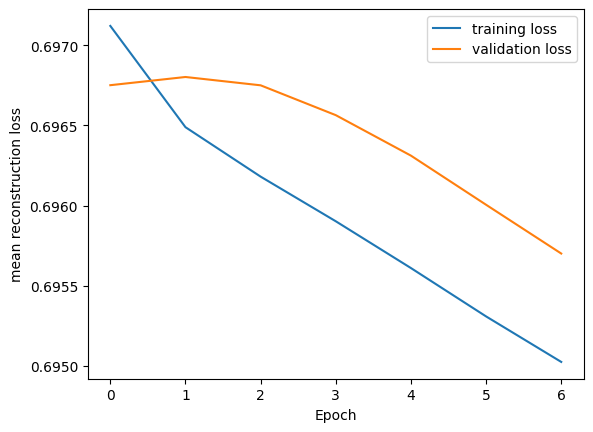

In [8]:
#plot training and validation loss by epoch 
fig, axs = plt.subplots()
axs.plot(per_epoch_loss_train, label="training loss")
axs.plot(per_epoch_loss_val, label="validation loss")
axs.set_xlabel("Epoch")
axs.set_ylabel("mean reconstruction loss")
axs.legend()

In [9]:
val_prediction = dna_classifier.predict(seqs_val)
#val prediction outputs values between 0 and 1. 
#rounding these values makes it either 1 (True) or 0 (False)
#np.mean() computes the fravtion of correct predictions. 
val_accuracy = np.mean(np.round(val_prediction) == labels_val)
print(f"final accuracy on validation set: {val_accuracy}")

final accuracy on validation set: 0.48946259220231825
